# ChartAF

## Configuration
### 1. API keys
#### (OPENAI_API_KEY, ANTHROPIC_API_KEY, GROQ_API_KEY, DEEPINFRA_API_KEY)
### 2. LLM that executes Data-to-Chart(d2c) task (d2c_model) 
#### Choose from ["gpt-4o" or "claude" or "gemma" or "llama"]
### 3. Index and Subindex from ChartUIE-8K dataset(IDX, SUB_IDX)
#### Index and Subindex must be specified based on the ChartUIE-8K dataset
### 4. Word count selection (WORD_COUNT)
#### configurates either lay user (50 words) or detailed user (100 words)[50 or 100]


In [1]:
from ChartAgent import ChartAgent
import os 
import yaml
import pprint
from LLM import LLM
import pandas as pd
import chardet
import json
import re

###################
######CONFIG#######
###################
# Set the API key and the D2C model

OPENAI_API_KEY = "<INSERT API KEY>"
ANTHROPIC_API_KEY = "<INSERT API KEY>"
GROQ_API_KEY = "<INSERT API KEY>"
DEEPINFRA_API_KEY = "<INSERT API KEY>"

d2c_model = "llama" # "gpt-4o" or "claude" or "llama" or "gemma"
ca_api_key = GROQ_API_KEY # OPENAI_API_KEY or ANTHROPIC_API_KEY or GROQ_API_KEY or DEEPINFRA_API_KEY
agent = ChartAgent(ca_api_key, d2c_model) 

IDX = 0
SUB_IDX = 0
WORD_COUNT = 50 # 50 or 100

data = None
data_path = f'ChartUIE_8K/data/{IDX}'

In [3]:
class CustomLoader(yaml.SafeLoader):
    pass

def construct_python_tuple(loader, node):
    # Extract the sequence (tuple) from the node and return only the first value
    tuple_value = loader.construct_sequence(node)
    return tuple_value[0] if tuple_value else None

# Add the constructor to handle the python/tuple tag
CustomLoader.add_constructor('tag:yaml.org,2002:python/tuple', construct_python_tuple)

def get_UIE(index, words_count, sub_index):
    # Define the base path for YAML files
    base_path = '../ChartUIE_8K'
    
    # Construct the full path to the YAML file
    yaml_file_path = os.path.join(base_path,
                                  'UIE_evaluation_set',
                                  str(index), 
                                  f'uie_sample_{index}_{words_count}_{sub_index}.yaml')
    
    # Read the YAML file using the custom loader
    with open(yaml_file_path, 'r', encoding='utf-8') as file:
        yaml_content = yaml.load(file, Loader=CustomLoader)
    
    # Return the value of '2. initial_prompt' along with the data summary
    return yaml_content

# get the UIE data
memory = get_UIE(IDX, WORD_COUNT, SUB_IDX)

directory, file_name_base = os.path.split(data_path)
# Browse all files in a directory
for filename in os.listdir(directory):
    base_name, fileformat = os.path.splitext(filename)
    if fileformat == '.csv' or fileformat == '.json' or fileformat == '.tsv':
        # Compare the given name with the part of the file name.
        if base_name == file_name_base or base_name.startswith(f"{file_name_base}_"):
            data_path = directory + '/' + filename
        else:
            Exception("No data file found")
            
# Read the data
if data_path.endswith('.csv') and not data_path.endswith('.json'):
     with open(data_path, 'rb') as f:
                result = chardet.detect(f.read(10000))
                encoding = result['encoding']
                data = pd.read_csv(data_path)# encoding=encoding)
                # Drop rows with NaN values
                #****************************
                # Get the columns from memory['05_data_attributes']
                columns_to_keep = memory['data_attributes']
                # Filter the data to keep only the specified columns
                data = data[columns_to_keep]
                #****************************

                data = data.dropna()
elif data_path.endswith('.json') and not data_path.endswith('.csv'):
    with open(data_path, 'r') as file:
        data = json.load(file)
elif data_path.endswith('.tsv') and not data_path.endswith('.csv'):
    data = pd.read_csv(data_path, sep='\t')
    columns_to_keep = memory['05_data_attributes']
    # Filter the data to keep only the specified columns
    data = data[columns_to_keep]
    data = data.dropna()
else:
    print("Unsupported data format. Please provide a CSV or JSON file.")

# d2c_model running the D2C task
memory = agent.run_d2c_task(data, data_path, IDX, memory)


{'answers': '1. I am not sure.\n'
            '2. I do not have a specific preference.\n'
            '3. I am not sure.\n'
            '4. I do not know.\n'
            '5. I am not sure.\n'
            '6. I do not have a specific preference.\n'
            '7. I do not know.\n'
            '8. I do not have a specific preference.\n'
            '9. I am not sure.\n'
            '10. I do not know.',
 'data_attributes': ['N', 'P', 'K', 'label'],
 'initial_prompt': 'Create a bar chart visualizing average N, P, K values for '
                   "different crops. Highlight the 'rice' values with distinct "
                   "colors. Include text annotations for crops 'rice' and "
                   "'wheat,' displaying their average N, P, K values. This "
                   'helps compare nutrient needs of various crops effectively.',
 'questions': '1. Do you have any specific color preferences for highlighting '
              "the 'rice' values?\n"
              '2. What colors would 

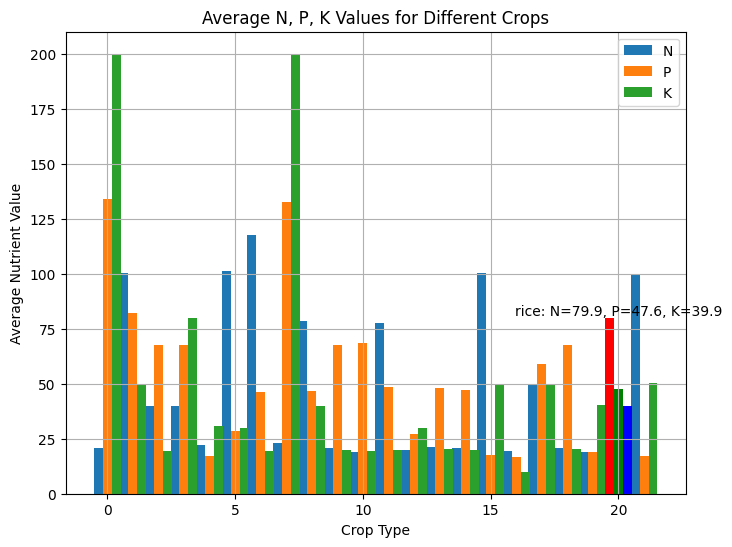

Plot saved and then shown


In [4]:
exec(memory['pre_feedback_code'])

In [5]:
# Load the initial D2C image
import base64
from autofeedback import AutoFeedback

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

d2c_image_path = [f"plots_d2c/{IDX}.png"]
d2c_image = []
for img_path in d2c_image_path:
    encoded_img = encode_image(img_path)
    d2c_image.append(encoded_img)

###################
#####AUTOJUDGE#####
###################
autofeedback = AutoFeedback(
    OPENAI_API_KEY,
    ANTHROPIC_API_KEY,
    d2c_image,
    memory,
    data
)


In [6]:
###################
######CHARTAF######
###################

# Giving 5 chances to get the feedback without JSONDecodeError

from json.decoder import JSONDecodeError
attempts = 0
max_attempts = 5

while attempts < max_attempts:
    try:
        autofeedback.judge()
        autofeedback.feedback()
        memory, feedback_gpt_classified, feedback_claude_classified, feedback_gpt_code, feedback_claude_code = autofeedback.feedback_parse()
        break  # Exit the loop if successful
    except JSONDecodeError as e:
        attempts += 1
        print(f"JSONDecodeError occurred: {e} (Attempt {attempts} of {max_attempts})")
        if attempts >= max_attempts:
            print("Maximum attempts reached. Exiting.")
    except Exception as e:
        print(f"An error occurred: {e}")
        break



###### Establishing Criteria ...
###### Creating Evaluation Questions ...
###### Evaluating ...
###### Parsing Visual Feedback ...
###### Generating Code Feedback ...
###### Parsing Code Feedback ...


In [7]:
feedback_json = autofeedback.memory['09_evaluation_vfeedback(claude)']
# Remove the leading "```json" and trailing "```" if present
feedback_json = feedback_json.strip()
if feedback_json.startswith("```json"):
    feedback_json = feedback_json[7:]
if feedback_json.endswith("```"):
    feedback_json = feedback_json[:-3]
# Remove any leading/trailing whitespace
feedback_json = feedback_json.strip()
feedback_dict = json.loads(feedback_json)
# Initialize a counter for 'YES' answers
yes_count = 0
# Iterate through each object in the evaluation list
for item in feedback_dict['evaluation']:
    # Check each key that starts with 'A' followed by a number
    for key in item.keys():
        if key.startswith('A') and key[1:].isdigit():
            if item[key] == 'YES':
                yes_count += 1
score = (yes_count/len(feedback_dict['evaluation']))*100
print(f"ChartAF-S(Claude) score: {score}")

feedback_json = autofeedback.memory['09_evaluation_vfeedback(gpt4o)']
# Remove the leading "```json" and trailing "```" if present
feedback_json = feedback_json.strip()
if feedback_json.startswith("```json"):
    feedback_json = feedback_json[7:]
if feedback_json.endswith("```"):
    feedback_json = feedback_json[:-3]
# Remove any leading/trailing whitespace
feedback_json = feedback_json.strip()
feedback_dict = json.loads(feedback_json)
# Initialize a counter for 'YES' answers
yes_count = 0
# Iterate through each object in the evaluation list
for item in feedback_dict['evaluation']:
    # Check each key that starts with 'A' followed by a number
    for key in item.keys():
        if key.startswith('A') and key[1:].isdigit():
            if item[key] == 'YES':
                yes_count += 1
score = (yes_count/len(feedback_dict['evaluation']))*100
print(f"ChartAF-S(GPT) score: {score}")


```json
{
    "evaluation":[
        {
            "Q1": "Does the chart effectively compare N, P, K values across different crops?",
            "A1": "YES",
            "Q_type": "Subjective",
            "feedback": [
                {
                    "tag": "RETAIN",
                    "improvement": "Bar chart format effectively showing N, P, K values for each crop"
                },
                {
                    "tag": "EDIT",
                    "improvement": "Improve x-axis labels to show actual crop names instead of numbers"
                }
            ]
        },
        {
            "Q2": "Are rice and wheat clearly distinguishable from other crops in the visualization?",
            "A2": "NO",
            "Q_type": "Fact-checking",
            "feedback": [
                {
                    "tag": "ADD",
                    "improvement": "Highlight rice and wheat bars with distinct colors or patterns"
                },
                {
           

In [8]:
######################
# D2C after feedback #
######################
post_feedback_gpt_code, post_feedback_claude_code = agent.run_d2c_task_with_feedback(
    feedback_gpt_classified, 
    feedback_claude_classified, 
    feedback_gpt_code, 
    feedback_claude_code, 
    IDX, 
    memory,
    True
    )

Memory updated and written to memory.json


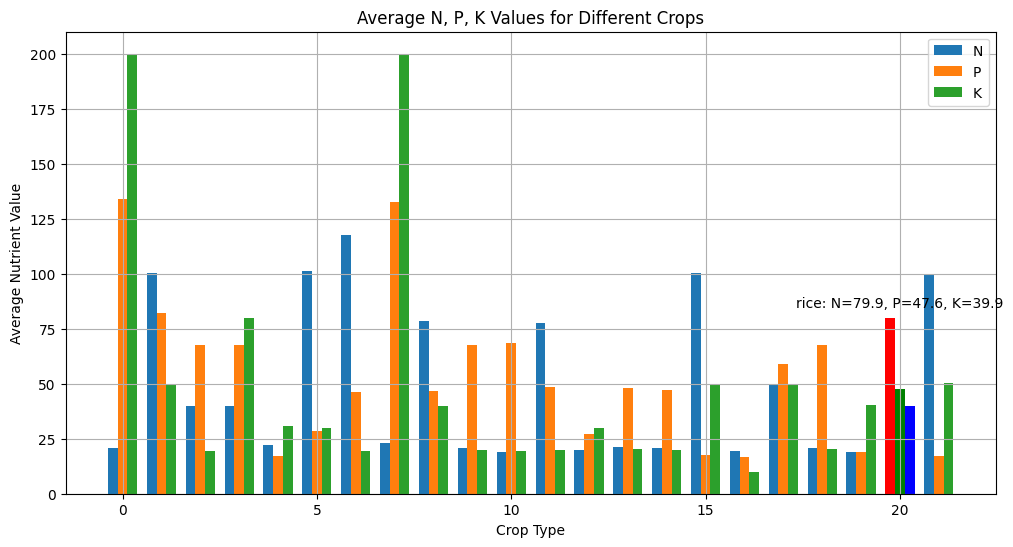

Plot saved and then shown


In [9]:
exec(post_feedback_gpt_code[0])

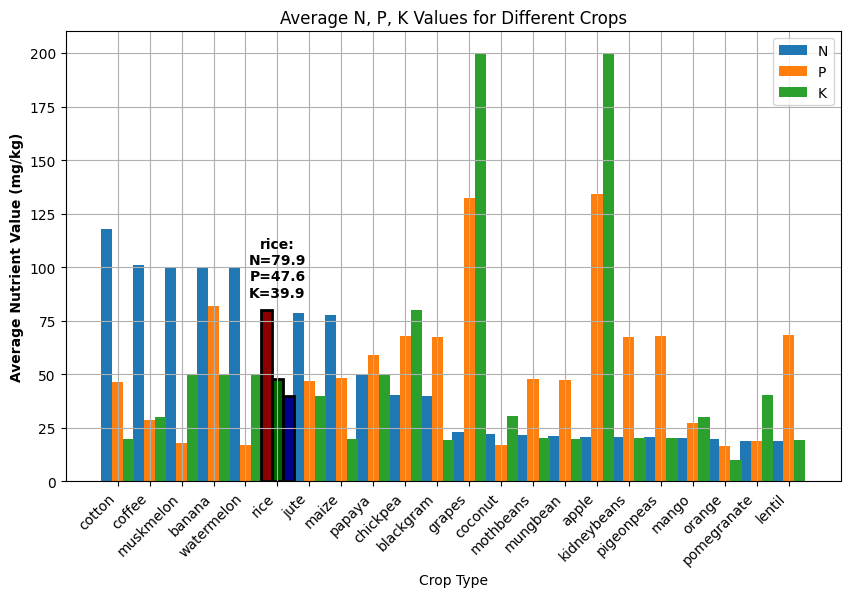

Plot saved and then shown


In [10]:
exec(post_feedback_claude_code[0])